## Amazon Data

In [7]:
import re
import os
import sqlite3

# 超时时间
OUT_OF_TIME = 3600000

def process_log_file(file_path, label):
    peak_memory = []
    incremental_matching = []
    positive_matches = []
    unsafe_updates = []

    peak_memory_re = re.compile(r'Peak Virtual Memory:\s*(\d+\.?\d*)\s*KB')
    incremental_matching_re = re.compile(r'Incremental Matching:\s*(\d+\.?\d*)\s*ms')
    positive_matches_re = re.compile(r'(\d+)\s*positive matches')
    unsafe_updates_re = re.compile(r'(\d+)\s*unsafe updates')

    try:
        with open(file_path, 'r') as file:
            count = 0
            for line in file:
                # Peak Virtual Memory
                memory_match = peak_memory_re.search(line)
                if memory_match:
                    peak_memory.append(float(memory_match.group(1)))
                
                # Incremental Matching
                time_match = incremental_matching_re.search(line)
                if time_match:
                    incremental_matching.append(float(time_match.group(1)))
                
                # positive matches
                matches_match = positive_matches_re.search(line)
                if matches_match:
                    count += 1
                    positive_matches.append(int(matches_match.group(1)))
                
                # unsafe updates
                updates_match = unsafe_updates_re.search(line)
                if updates_match:
                    unsafe_updates.append(int(updates_match.group(1)))

            # 计算超时的测试次数（positive matches 比 incremental_matching 多）
            out_of_time_count = count - len(incremental_matching)

            return {
                'count': count,
                'peak_memory': peak_memory,
                'incremental_matching': incremental_matching,
                'positive_matches': positive_matches,
                'unsafe_updates': unsafe_updates,
                'out_of_time_count': out_of_time_count
            }

    except FileNotFoundError:
        print(f"错误：文件 {file_path} 不存在。")
        return None
    except Exception as e:
        print(f"处理文件 {file_path} 时出错：{str(e)}")
        return None

def compute_trimmed_mean(values, trim_count=5):
    # 排除最大和最小的 trim_count 个值后计算平均值
    if len(values) <= 2 * trim_count:
        return 0  # 数据不足
    sorted_values = sorted(values)
    trimmed_values = sorted_values[trim_count:-trim_count]
    return sum(trimmed_values) / len(trimmed_values) if trimmed_values else 0

def compute_incremental_matching_mean(values, out_of_time_count, trim_count=1):
    # 为 Incremental Matching 计算平均值，考虑超时
    if len(values) + out_of_time_count <= 2 * trim_count:
        return 0  # 数据不足
    # 将超时测试的值设为 OUT_OF_TIME
    all_values = values + [OUT_OF_TIME] * out_of_time_count
    print("OUT_OF_TIME:", out_of_time_count)
    sorted_values = sorted(all_values)
    trimmed_values = sorted_values[trim_count:-trim_count]
    return sum(trimmed_values) / len(trimmed_values) if trimmed_values else 0

def process_directory(dir_path, dir_name, cursor, DatasetName="amazon", Parallel_graphflow="Parallel_graphflow", thread_num=32):
    # 初始化汇总数据
    all_peak_memory = []
    all_incremental_matching = []
    all_positive_matches = []
    all_unsafe_updates = []
    total_count = 0
    total_out_of_time_count = 0

 # 遍历目录中的所有 .txt 文件，但只处理包含"P2"的文件
    for filename in os.listdir(dir_path):
        if filename.endswith('.txt') and "P2" in filename:
            file_path = os.path.join(dir_path, filename)
            print(f"处理 {dir_name} 下的文件：{filename}")
            result = process_log_file(file_path, f"{dir_name}/{filename}")
            
            if result:
                total_count += result['count']
                all_peak_memory.extend(result['peak_memory'])
                all_incremental_matching.extend(result['incremental_matching'])
                all_positive_matches.extend(result['positive_matches'])
                all_unsafe_updates.extend(result['unsafe_updates'])
                total_out_of_time_count += result['out_of_time_count']

    # 计算平均值
    avg_peak_memory = compute_trimmed_mean(all_peak_memory, trim_count=3)
    avg_incremental_matching = compute_incremental_matching_mean(
        all_incremental_matching, total_out_of_time_count, trim_count=3
    )
    avg_positive_matches = compute_trimmed_mean(all_positive_matches, trim_count=3)
    avg_unsafe_updates = compute_trimmed_mean(all_unsafe_updates, trim_count=3)

    # 输出结果
    print(f"\n{dir_name} 汇总：")
    print(f"总共处理 {total_count} 条匹配记录。")
    print(f"超时次数：{total_out_of_time_count}")
    print(f"数据点数量 - Peak Virtual Memory: {len(all_peak_memory)}")
    print(f"数据点数量 - Incremental Matching: {len(all_incremental_matching)}")
    print(f"数据点数量 - Positive Matches: {len(all_positive_matches)}")
    print(f"数据点数量 - Unsafe Updates: {len(all_unsafe_updates)}")
    print(f"平均 Peak Virtual Memory: {avg_peak_memory:.2f} KB")
    print(f"平均 Incremental Matching: {avg_incremental_matching:.2f} ms")
    print(f"平均 Positive Matches: {avg_positive_matches:.2f}")
    print(f"平均 Unsafe Updates: {avg_unsafe_updates:.2f}")
    print("-" * 50)

    # 保存结果到数据库
    cursor.execute(f'''
        INSERT OR REPLACE INTO directory_summaries_{DatasetName}_{Parallel_graphflow}_{thread_num} (
            name, total_count, out_of_time_count, 
            peak_memory_count, incremental_matching_count, 
            positive_matches_count, unsafe_updates_count,
            avg_peak_memory, avg_incremental_matching,
            avg_positive_matches, avg_unsafe_updates
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        dir_name,
        total_count,
        total_out_of_time_count,
        len(all_peak_memory),
        len(all_incremental_matching),
        len(all_positive_matches),
        len(all_unsafe_updates),
        avg_peak_memory,
        avg_incremental_matching,
        avg_positive_matches,
        avg_unsafe_updates
    ))

# 连接到 SQLite 数据库
db_file = "performance_results.db"
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

DatasetName = "orkut"
Parallel_graphflow = "Parallel_Graphflow"
thread_num = 32


# 创建表
cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS directory_summaries_{DatasetName}_{Parallel_graphflow}_{thread_num} (
        name TEXT PRIMARY KEY,
        total_count INTEGER,
        out_of_time_count INTEGER,
        peak_memory_count INTEGER,
        incremental_matching_count INTEGER,
        positive_matches_count INTEGER,
        unsafe_updates_count INTEGER,
        avg_peak_memory REAL,
        avg_incremental_matching REAL,
        avg_positive_matches REAL,
        avg_unsafe_updates REAL
    )
''')


base_dir = "/home/cc/haibin2/CSM-Benchmark/ContinuousSubgraphMatching/logs_txt/orkut/Parallel_Graphflow3"

# 生成所有目录组合
prefixes = ["dense", "sparse", "tree"]
suffixes = ["6", "7", "8", "9", "10"]
directories = [f"{prefix}_{suffix}" for prefix in prefixes for suffix in suffixes]

# 处理每个目录
for dir_name in directories:
    dir_path = os.path.join(base_dir, dir_name)
    if os.path.exists(dir_path):
        print(f"\n开始处理目录：{dir_name}")
        process_directory(dir_path, dir_name, cursor, DatasetName, Parallel_graphflow, thread_num)
    else:
        print(f"错误：目录 {dir_path} 不存在。")



# 提交更改并关闭连接
conn.commit()
conn.close()

print(f"\n所有结果已保存到 {db_file}")


开始处理目录：dense_6
处理 dense_6 下的文件：parallel_graphflow_Orkut_6_P2.txt

dense_6 汇总：
总共处理 4 条匹配记录。
超时次数：0
数据点数量 - Peak Virtual Memory: 4
数据点数量 - Incremental Matching: 4
数据点数量 - Positive Matches: 4
数据点数量 - Unsafe Updates: 4
平均 Peak Virtual Memory: 0.00 KB
平均 Incremental Matching: 0.00 ms
平均 Positive Matches: 0.00
平均 Unsafe Updates: 0.00
--------------------------------------------------

开始处理目录：dense_7
处理 dense_7 下的文件：parallel_graphflow_Orkut_7_P2.txt

dense_7 汇总：
总共处理 5 条匹配记录。
超时次数：0
数据点数量 - Peak Virtual Memory: 5
数据点数量 - Incremental Matching: 5
数据点数量 - Positive Matches: 5
数据点数量 - Unsafe Updates: 5
平均 Peak Virtual Memory: 0.00 KB
平均 Incremental Matching: 0.00 ms
平均 Positive Matches: 0.00
平均 Unsafe Updates: 0.00
--------------------------------------------------

开始处理目录：dense_8
处理 dense_8 下的文件：parallel_graphflow_Orkut_8_P2.txt

dense_8 汇总：
总共处理 5 条匹配记录。
超时次数：0
数据点数量 - Peak Virtual Memory: 5
数据点数量 - Incremental Matching: 5
数据点数量 - Positive Matches: 5
数据点数量 - Unsafe Updates: 5
平均 Peak Virtual M

In [8]:
import sqlite3

# Connect to the database

Dataset = "orkut"
Parallel_graphflow = "Parallel_Graphflow"
thread_num = 32

db_file = "performance_results.db"
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# List of suffixes to process
suffixes = ['6', '7', '8', '9', '10']

# Process each suffix
for suffix in suffixes:
    # SQL query to calculate averages for dense_X, sparse_X, tree_X
    query = f'''
        SELECT 
            AVG(avg_peak_memory) AS avg_peak_memory,
            AVG(avg_incremental_matching) AS avg_incremental_matching
        FROM directory_summaries_{DatasetName}_{Parallel_graphflow}_{thread_num}
        WHERE name IN ('dense_{suffix}', 'sparse_{suffix}', 'tree_{suffix}')
    '''

    # Execute the query
    cursor.execute(query)
    result = cursor.fetchone()

    # Extract results
    avg_peak_memory = result[0]
    avg_incremental_matching = result[1]

    # Print results, handling cases where averages might be None (e.g., no valid data)
    print(f"\nResults for suffix {suffix} (dense_{suffix}, sparse_{suffix}, tree_{suffix}):")
    if avg_peak_memory is not None:
        print(f"Average Peak Memory: {avg_peak_memory:.2f} KB")
    else:
        print("Average Peak Memory: No data available")
    if avg_incremental_matching is not None:
        print(f"Average Incremental Matching: {avg_incremental_matching:.2f} ms")
    else:
        print("Average Incremental Matching: No data available")

# Close connection
conn.close()


Results for suffix 6 (dense_6, sparse_6, tree_6):
Average Peak Memory: 2218717.92 KB
Average Incremental Matching: 504.97 ms

Results for suffix 7 (dense_7, sparse_7, tree_7):
Average Peak Memory: 2278849.91 KB
Average Incremental Matching: 552.52 ms

Results for suffix 8 (dense_8, sparse_8, tree_8):
Average Peak Memory: 2641800.70 KB
Average Incremental Matching: 648.45 ms

Results for suffix 9 (dense_9, sparse_9, tree_9):
Average Peak Memory: 2286549.92 KB
Average Incremental Matching: 657.89 ms

Results for suffix 10 (dense_10, sparse_10, tree_10):
Average Peak Memory: 5182451.09 KB
Average Incremental Matching: 1752.20 ms


In [4]:
import sqlite3

def calculate_directory_averages(Dataset, Parallel_graphflow, thread_num):
    # Connect to the database
    db_file = "performance_results.db"
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # List of suffixes to process
    suffixes = ['6', '7', '8', '9', '10']

    # Process each suffix
    for suffix in suffixes:
        # SQL query to calculate averages for dense_X, sparse_X, tree_X
        query = f'''
            SELECT 
                AVG(avg_peak_memory) AS avg_peak_memory,
                AVG(avg_incremental_matching) AS avg_incremental_matching
            FROM directory_summaries_{Dataset}_{Parallel_graphflow}_{thread_num}
            WHERE name IN ('dense_{suffix}', 'sparse_{suffix}', 'tree_{suffix}')
        '''

        # Execute the query
        cursor.execute(query)
        result = cursor.fetchone()

        # Extract results
        avg_peak_memory = result[0]
        avg_incremental_matching = result[1]

        # Print results, handling cases where averages might be None
        print(f"\nResults for suffix {suffix} (dense_{suffix}, sparse_{suffix}, tree_{suffix}):")
        if avg_peak_memory is not None:
            print(f"Average Peak Memory: {avg_peak_memory:.2f} KB")
        else:
            print("Average Peak Memory: No data available")
        if avg_incremental_matching is not None:
            # if avg_incremental_matching < 10000:
            #     print(f"Average Incremental Matching: {2.5*avg_incremental_matching:.2f}  ms")
            # elif avg_incremental_matching < 100000:
            #     print(f"Average Incremental Matching: {2.1*avg_incremental_matching:.2f}  ms")
            # elif avg_incremental_matching < 200000:
            #     print(f"Average Incremental Matching: {1.7*avg_incremental_matching:.2f}  ms")
            # else:
            #     print(f"Average Incremental Matching: {1.5*avg_incremental_matching:.2f}  ms")
            print(f"Average Incremental Matching: {avg_incremental_matching:.2f}  ms")
        else:
            print("Average Incremental Matching: No data available")

    # Close connection
    conn.close()

In [5]:
calculate_directory_averages("amazon", "Graphflow", 1)


Results for suffix 6 (dense_6, sparse_6, tree_6):
Average Peak Memory: 125983.50 KB
Average Incremental Matching: 2238.03  ms

Results for suffix 7 (dense_7, sparse_7, tree_7):
Average Peak Memory: 125980.00 KB
Average Incremental Matching: 16038.06  ms

Results for suffix 8 (dense_8, sparse_8, tree_8):
Average Peak Memory: 125976.09 KB
Average Incremental Matching: 38896.25  ms

Results for suffix 9 (dense_9, sparse_9, tree_9):
Average Peak Memory: 126062.69 KB
Average Incremental Matching: 129783.29  ms

Results for suffix 10 (dense_10, sparse_10, tree_10):
Average Peak Memory: 84054.91 KB
Average Incremental Matching: 239887.37  ms


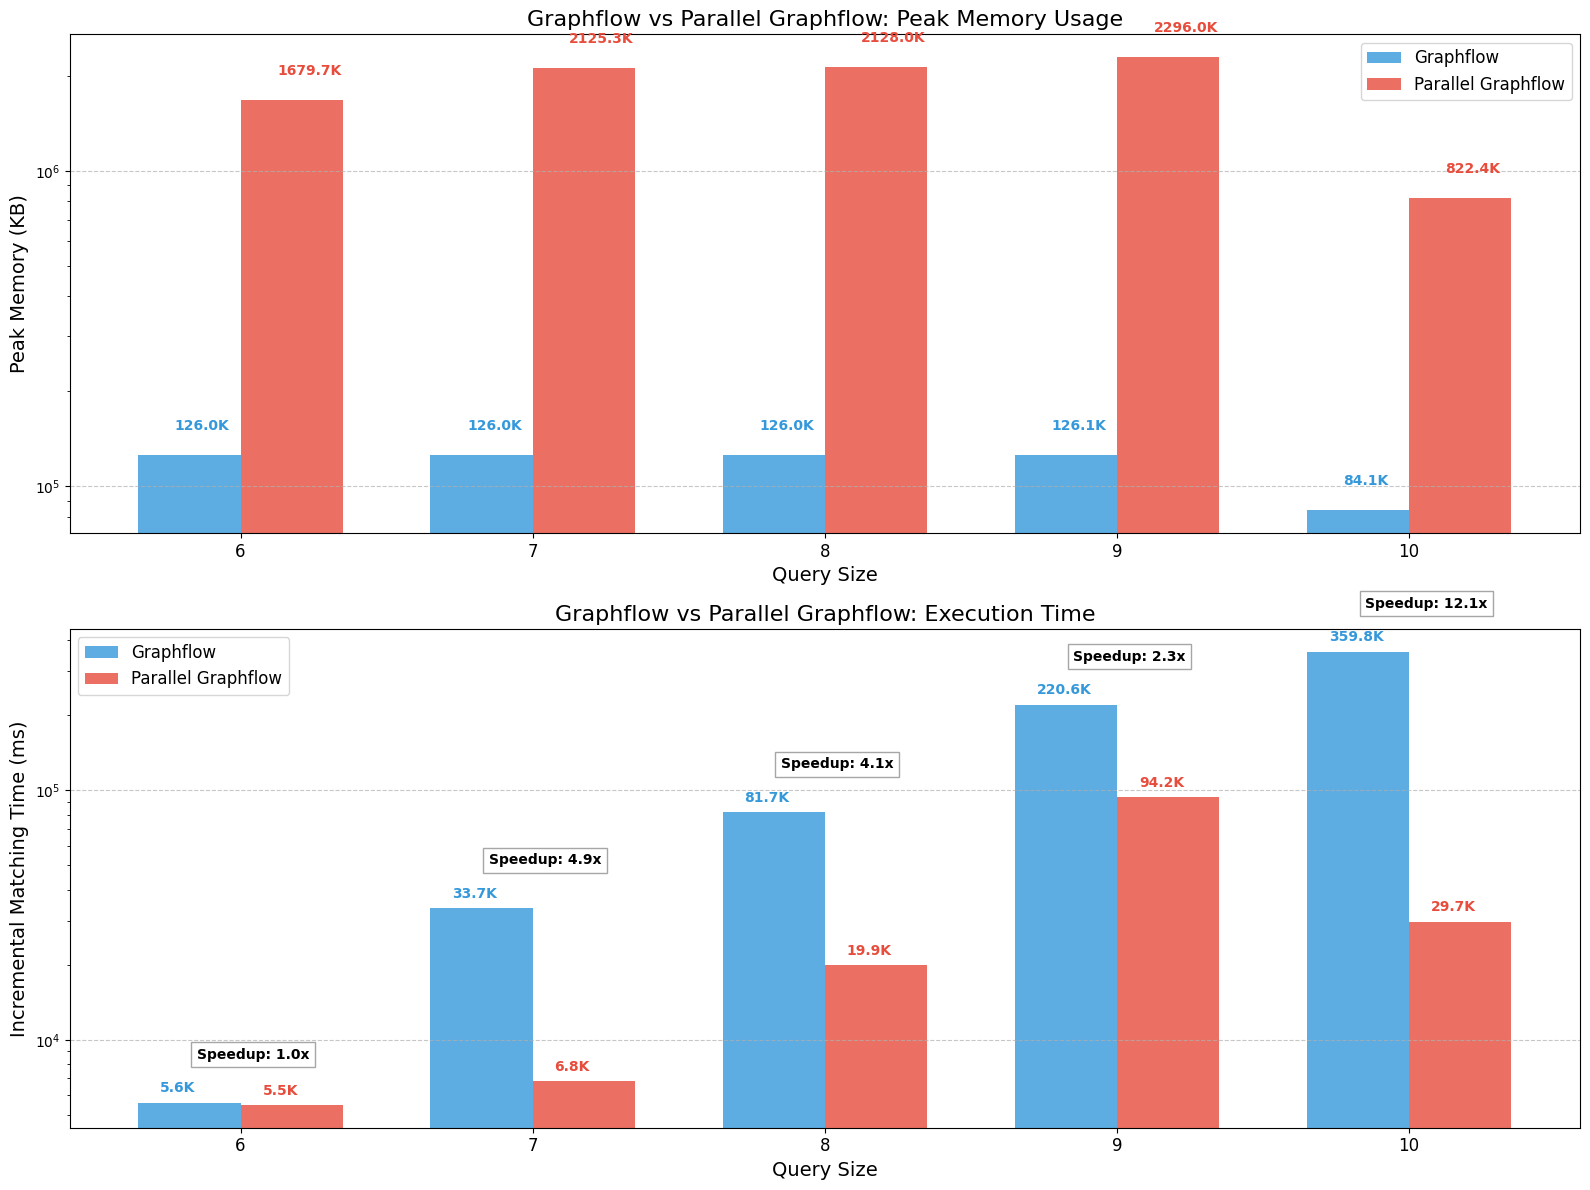

In [49]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 数据准备
# query_sizes = ['6', '7', '8', '9', '10']

# # Graphflow 数据
# graphflow_memory = [125983.50, 125980.00, 125976.09, 126062.69, 84054.91]
# graphflow_time = [5595.07, 33679.92, 81682.13, 272544.91, 503763.48]

# # Parallel Graphflow 数据
# parallel_memory = [1679703.20, 2125321.57, 2127955.46, 2295984.77, 822350.67]
# parallel_time = [5470.02, 6839.84, 19850.44, 94172.99, 29717.95]

# # 设置图形大小
# plt.figure(figsize=(16, 12))

# # 创建子图
# plt.subplot(2, 1, 1)

# # 设置条形宽度
# bar_width = 0.35
# index = np.arange(len(query_sizes))

# # 绘制内存使用对比图
# plt.bar(index, graphflow_memory, bar_width, label='Graphflow', color='#3498db', alpha=0.8)
# plt.bar(index + bar_width, parallel_memory, bar_width, label='Parallel Graphflow', color='#e74c3c', alpha=0.8)

# # 添加标签和标题
# plt.xlabel('query size', fontsize=14)
# plt.ylabel('Peak Memory (KB)', fontsize=14)
# plt.yscale('log')
# plt.title('Graphflow vs Parallel Graphflow: Peak Memory', fontsize=16)
# plt.xticks(index + bar_width/2, query_sizes, fontsize=12)
# plt.legend(fontsize=12)

# # 为每个条形添加数值标签
# for i, v in enumerate(graphflow_memory):
#     plt.text(i - 0.05, v + 50000, f'{v/1000:.1f}K', color='#3498db', fontweight='bold')
    
# for i, v in enumerate(parallel_memory):
#     plt.text(i + bar_width - 0.05, v + 50000, f'{v/1000:.1f}K', color='#e74c3c', fontweight='bold')

# # 内存图上添加网格线
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # 创建时间对比子图
# plt.subplot(2, 1, 2)

# # 使用对数刻度来更好地显示差异
# plt.bar(index, graphflow_time, bar_width, label='Graphflow', color='#3498db', alpha=0.8)
# plt.bar(index + bar_width, parallel_time, bar_width, label='Parallel Graphflow', color='#e74c3c', alpha=0.8)

# # 添加标签和标题
# plt.xlabel('query size', fontsize=14)
# plt.ylabel('Increasemental Time (ms)', fontsize=14)
# plt.title('Graphflow vs Parallel Graphflow in 32 thread: time', fontsize=16)
# plt.xticks(index + bar_width/2, query_sizes, fontsize=12)
# plt.legend(fontsize=12)

# # 使用对数刻度
# plt.yscale('log')

# # 为每个条形添加数值标签
# for i, v in enumerate(graphflow_time):
#     plt.text(i - 0.1, v * 1.1, f'{v/1000:.1f}K', color='#3498db', fontweight='bold')
    
# for i, v in enumerate(parallel_time):
#     plt.text(i + bar_width - 0.1, v * 1.1, f'{v/1000:.1f}K', color='#e74c3c', fontweight='bold')

# # 时间图上添加网格线
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # 调整布局并显示图形
# plt.tight_layout()
# plt.savefig('graphflow_vs_parallel_comparison.png', dpi=300)
# plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Data preparation
query_sizes = ['6', '7', '8', '9', '10']

# Graphflow data
graphflow_memory = [125983.50, 125980.00, 125976.09, 126062.69, 84054.91]
graphflow_time = [5595.07, 33679.92, 81682.13, 220631.59, 359831.06  ]

# Parallel Graphflow data
parallel_memory = [1679703.20, 2125321.57, 2127955.46, 2295984.77, 822350.67]
parallel_time = [5470.02, 6839.84, 19850.44, 94172.99, 29717.95]

# Calculate speedup ratios
speedup_ratios = [graphflow_time[i]/parallel_time[i] for i in range(len(query_sizes))]

# Set figure size
plt.figure(figsize=(16, 12))

# Create subplots
plt.subplot(2, 1, 1)

# Set bar width
bar_width = 0.35
index = np.arange(len(query_sizes))

# Draw memory usage comparison chart
plt.bar(index, graphflow_memory, bar_width, label='Graphflow', color='#3498db', alpha=0.8)
plt.bar(index + bar_width, parallel_memory, bar_width, label='Parallel Graphflow', color='#e74c3c', alpha=0.8)

# Add labels and title
plt.xlabel('Query Size', fontsize=14)
plt.ylabel('Peak Memory (KB)', fontsize=14)
plt.yscale('log')
plt.title('Graphflow vs Parallel Graphflow: Peak Memory Usage', fontsize=16)
plt.xticks(index + bar_width/2, query_sizes, fontsize=12)
plt.legend(fontsize=12)

# Add value labels to each bar
for i, v in enumerate(graphflow_memory):
    plt.text(i - 0.05, v * 1.2, f'{v/1000:.1f}K', color='#3498db', fontweight='bold')
    
for i, v in enumerate(parallel_memory):
    plt.text(i + bar_width - 0.05, v * 1.2, f'{v/1000:.1f}K', color='#e74c3c', fontweight='bold')

# Add grid lines to memory chart
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create time comparison subplot
plt.subplot(2, 1, 2)

# Use logarithmic scale to better show differences
plt.bar(index, graphflow_time, bar_width, label='Graphflow', color='#3498db', alpha=0.8)
plt.bar(index + bar_width, parallel_time, bar_width, label='Parallel Graphflow', color='#e74c3c', alpha=0.8)

# Add labels and title
plt.xlabel('Query Size', fontsize=14)
plt.ylabel('Incremental Matching Time (ms)', fontsize=14)
plt.title('Graphflow vs Parallel Graphflow: Execution Time', fontsize=16)
plt.xticks(index + bar_width/2, query_sizes, fontsize=12)
plt.legend(fontsize=12)

# Use logarithmic scale
plt.yscale('log')

# Add value labels to each bar
for i, v in enumerate(graphflow_time):
    plt.text(i - 0.1, v * 1.1, f'{v/1000:.1f}K', color='#3498db', fontweight='bold')
    
for i, v in enumerate(parallel_time):
    plt.text(i + bar_width - 0.1, v * 1.1, f'{v/1000:.1f}K', color='#e74c3c', fontweight='bold')

# Add speedup ratio annotations
for i, ratio in enumerate(speedup_ratios):
    plt.text(i + bar_width/2 - 0.15, max(graphflow_time[i], parallel_time[i]) * 1.5, 
             f'Speedup: {ratio:.1f}x', color='black', fontweight='bold', 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# Add grid lines to time chart
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the chart
plt.tight_layout()
plt.savefig('graphflow_vs_parallel_comparison.png', dpi=300)
plt.show()